<a href="https://colab.research.google.com/github/yukinaga/twitter_bot/blob/master/section_2/03_simple_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなseq2seq
最小限のSeq2Seqを構築し、時系列の変換を行います。  
今回は、Seq2Seqを使って、sin関数の曲線をcos関数の曲線に”翻訳”します。  
Seq2Seqの構築方法について、基礎から学んでいきましょう。

## 訓練用データの作成
訓練用のデータを作成します。  
今回は、sin関数の値をencoderへの入力、cos関数の値をdecoderへの入力、及び正解とします。  
decoderへの入力は、正解から一つ後の時刻にずらします。  
これにより、ある時刻におけるdecoderの出力が、次の時刻における入力に近づくように学習を行うことができます。  
このような、ある時刻における正解が次の時刻の入力となる手法を「教師強制」といいます。

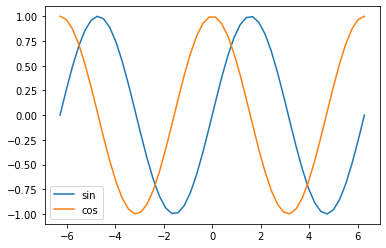

In [1]:
import numpy as np
import matplotlib.pyplot as plt

axis_x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_data = np.sin(axis_x)  # sin関数
cos_data = np.cos(axis_x)  # cos関数

plt.plot(axis_x, sin_data, label="sin")
plt.plot(axis_x, cos_data, label="cos")
plt.legend()
plt.show()

n_time = 10  # 時系列の数
n_sample = len(axis_x)-n_time  # サンプル数
x_encoder = np.zeros((n_sample, n_time))  # encoderの入力
x_decoder = np.zeros((n_sample, n_time))  # decoderの入力
t_decoder = np.zeros((n_sample, n_time))  # decoderの正解

for i in range(0, n_sample):
    x_encoder[i] = sin_data[i:i+n_time]
    x_decoder[i, 1:] = cos_data[i:i+n_time-1]  # 一つ後の時刻にずらす。最初の値は0のまま。
    t_decoder[i] = cos_data[i:i+n_time]  # 正解は、cos関数の値をそのまま入れる

x_encoder = x_encoder.reshape(n_sample, n_time, 1)  # （サンプル数、時系列の数、入力層のニューロン数）
x_decoder = x_decoder.reshape(n_sample, n_time, 1)
t_decoder = t_decoder.reshape(n_sample, n_time, 1)

## 各設定
Encoderの入力、Decoderの入力、Decoderの正解をデータセットにまとめ、DataLoaderに設定します。  
また、各層のニューロン数も設定します。



In [2]:
import torch
from torch.utils.data import DataLoader

x_encoder = torch.tensor(x_encoder, dtype=torch.float)  # テンソルに変換
x_decoder = torch.tensor(x_decoder, dtype=torch.float)
t_decoder = torch.tensor(t_decoder, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(x_encoder, x_decoder, t_decoder)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoaderの設定

n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = n_in  # 出力層のニューロン数

## Encoderのクラス
Encoderをクラスとして実装します。  
RNN部分にはシンプルなRNNを使用します。  

In [3]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super().__init__()
        
        self.n_mid = n_mid
        
        self.rnn = nn.RNN(  # RNN層
            input_size=n_in,  # 入力サイズ
            hidden_size=n_mid,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )

    def forward(self, x_encoder):
        y_encoder, h_encoder = self.rnn(x_encoder)
        return h_encoder

## Decoderのクラス
Encoderをクラスとして実装します。  
RNN部分にはシンプルなRNNを使用します。  
RNNの出力は、全結合層を経てDecoderの出力となります。

In [4]:
class Decoder(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super().__init__()
        
        self.n_mid = n_mid
        self.n_out = n_out
                
        self.rnn = nn.RNN(  # RNN層
            input_size=n_in,  # 入力サイズ
            hidden_size=n_mid,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(n_mid, n_out)
                
    def forward(self, x_decoder, h_encoder):
        y_decoder, h_decoder = self.rnn(x_decoder, h_encoder)
        y_decoder = self.fc(y_decoder)
        return y_decoder, h_decoder

## Seq2Seqのクラス
PyTorchを使ってSeq2Seqを構築します。  
今回は、Seq2SeqのRNN部分にはシンプルなRNNを使います。  
訓練用の`forward`メソッドと、予測用の`predict`メソッドを用意します。  
訓練では、予め用意したDecoderの入力を使用します。  
予測では、各時刻ごとの出力が次の時刻の入力となるので、Seq2Seqによりデータが生成されることになります。

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x_encoder, x_decoder):  # 訓練に使用
        batch_size = x_decoder.shape[0]
        n_time = x_decoder.shape[1]
        h = self.encoder(x_encoder)

        y_decoder = torch.zeros(batch_size, n_time, self.decoder.n_out)   

        for t in range(0, n_time):
            x = x_decoder[:, t:t+1, :]  # Decoderの入力を使用
            y, h= self.decoder(x, h)
            y_decoder[:, t:t+1, :] = y  
        return y_decoder

    def predict(self, x_encoder):  # 予測に使用
        batch_size = x_encoder.shape[0]
        n_time = x_encoder.shape[1]
        h = self.encoder(x_encoder)

        y_decoder = torch.zeros(batch_size, n_time, self.decoder.n_out)   
        y = torch.zeros(batch_size, 1, self.decoder.n_out)   
        for t in range(0, n_time):
            x = y  # 前の時刻の出力を入力に
            y, h= self.decoder(x, h)
            y_decoder[:, t:t+1, :] = y  
        return y_decoder

## 学習
DataLoaderを使ってミニバッチを取り出し、Seq2Seqのモデルを訓練します。  


In [6]:
from torch import optim

# Seq2Seqのモデルを構築
encoder = Encoder(n_in, n_mid, n_out)
decoder = Decoder(n_in, n_mid, n_out)
seq2seq = Seq2Seq(encoder, decoder)

# 二乗和誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.SGD(seq2seq.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []

# 学習
seq2seq.train()  # 訓練モード
for i in range(500):  # 500エポック学習
    loss_train = 0
    for j, (x_enc, x_dec, t_dec) in enumerate(train_loader):  # ミニバッチを取り出す
        y_dec = seq2seq(x_enc, x_dec)
        loss = loss_fnc(y_dec, t_dec)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)
    if i%50 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)

Epoch: 0 Loss_Train: 0.5359700202941895
Epoch: 50 Loss_Train: 0.055730854719877244
Epoch: 100 Loss_Train: 0.014402008429169656
Epoch: 150 Loss_Train: 0.00613300921395421
Epoch: 200 Loss_Train: 0.0030803073663264514
Epoch: 250 Loss_Train: 0.0022622999735176564
Epoch: 300 Loss_Train: 0.0019565708003938197
Epoch: 350 Loss_Train: 0.0017774258740246296
Epoch: 400 Loss_Train: 0.0016416424186900258
Epoch: 450 Loss_Train: 0.001537606306374073


## 誤差の推移
誤差の推移をグラフ表示します。  

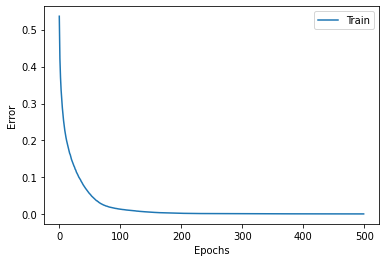

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 翻訳を実行
sin関数の曲線を、cos関数の曲線に”翻訳”します。  


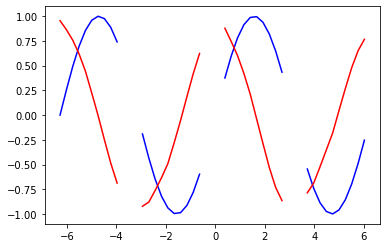

In [8]:
seq2seq.eval()  # 評価モード
demo_idices = [0, 13, 26, 39]  # デモに使うデータのインデックス
for i in demo_idices:
    x_demo = x_encoder[i:i+1]  # 入力を一部取り出す
    y_demo = seq2seq.predict(x_demo)  # 翻訳する
    
    plt.plot(axis_x[i:i+n_time], x_demo.reshape(-1), color="b")  # 翻訳前（青）
    plt.plot(axis_x[i:i+n_time], y_demo.view(-1).detach(), color="r")  # 翻訳後（赤）
    
plt.show()    